In [31]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

# Loading the data

In [32]:
path = 'wonderland.txt'
text = open(path, encoding="utf8").read().lower()
print('corpus length:', len(text))

corpus length: 11295


# Preprocessing

In [37]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'unique chars: {len(chars)}')

unique chars: 46


In [38]:
SEQUENCE_LENGTH = 40
step = 2
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 5628


# generating our features and labels

In [39]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [40]:
sentences[100]

's saved one and two at a time by bulldoz'

# The character that needs to be predicted for it is:

In [41]:
next_chars[100]

'i'

In [42]:
print (X[0][0])
print (X.shape)
print (y[0][0])
print (y.shape)


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True]
(5628, 40, 46)
False
(5628, 46)


# Building the model

In [43]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

In [44]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=50, shuffle=True).history

Train on 5346 samples, validate on 282 samples
Epoch 1/50
5346/5346 [==============================] - 21s - loss: 3.1240 - acc: 0.1706 - val_loss: 2.8441 - val_acc: 0.1525
Epoch 2/50
5346/5346 [==============================] - 15s - loss: 2.7292 - acc: 0.2400 - val_loss: 2.5710 - val_acc: 0.2695
Epoch 3/50
5346/5346 [==============================] - 16s - loss: 2.4716 - acc: 0.3034 - val_loss: 2.4379 - val_acc: 0.2730
Epoch 4/50
5346/5346 [==============================] - 15s - loss: 2.3214 - acc: 0.3350 - val_loss: 2.3812 - val_acc: 0.2624
Epoch 5/50
5346/5346 [==============================] - 14s - loss: 2.2041 - acc: 0.3605 - val_loss: 2.2862 - val_acc: 0.2943
Epoch 6/50
5346/5346 [==============================] - 14s - loss: 2.0842 - acc: 0.3915 - val_loss: 2.2466 - val_acc: 0.3014
Epoch 7/50
5346/5346 [==============================] - 14s - loss: 1.9800 - acc: 0.4160 - val_loss: 2.2543 - val_acc: 0.3085
Epoch 8/50
5346/5346 [==============================] - 14s - loss: 1.8

# Saving Model

In [45]:
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

In [46]:
model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

# Evaluatplt.plot(history['acc'])


In [1]:
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

NameError: name 'plt' is not defined

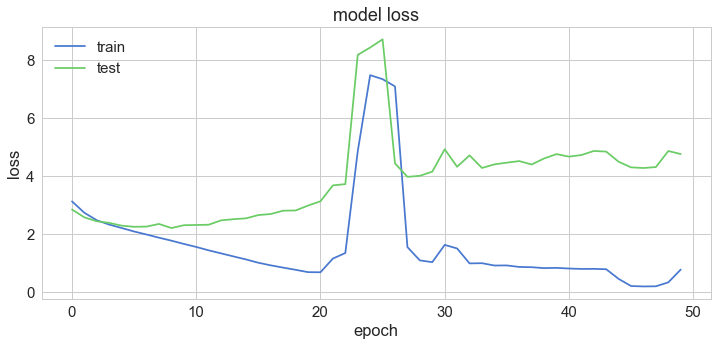

In [48]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

# Test

In [49]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [50]:
prepare_input("This is an example of input for our LSTM".lower())

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])

In [51]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [52]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

# predict multiple completions:

In [53]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [54]:
quotes = [
    "So now Della's beautiful hair fell about her rippling and shining",
    "When Della reached home her intoxication gave way a little to.",
    "White fingers and nimble tore at the string and paper.",
    "Within forty minutes her head was covered with tiny",
    "She had a habit of saying a little silent prayer"
]

In [55]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

so now della's beautiful hair fell about
[' the ', 'ou ', '. ', 's ', '\nthe ']

when della reached home her intoxication
['. ', '-was ', ' geve ', ', ', '\nwas ']

white fingers and nimble tore at the str
['entir ', 'ops ', 'ing ', 'ape ', 'sen ']

within forty minutes her head was covere
['d ', ' the ', 'r ', 'ntired ', '. ']

she had a habit of saying a little silen
['glap ', "'m ", 't ', 'ed ', ', ']

